# Trabalho - Redes Adversárias

---

As redes adversárias é basicamente uma forma de treinar um modelo generativo usando um problema de aprendizado supervisionado.

Existem 2 requisitos básicos, nomeadamente, Gerador: Modelo usado para gerar amostras plausíveis ou falsas a partir de amostras já disponíveis e discriminador: Modelo usado para classificar as amostras fornecidas como reais ou falsas.

Os dois modelos são treinados juntos em uma espécie jogo até que o discriminador seja enganado na metade das vezes.

Um único ciclo de treinamento envolve primeiro selecionar um lote de imagens reais do domínio do problema. Um lote de pontos latentes é gerado e alimentado ao modelo gerador para sintetizar um lote de imagens.
O discriminador é então atualizado usando o lote de imagens reais e geradas, minimizando a perda de entropia cruzada binária usada em qualquer problema de classificação binária. O gerador é então atualizado por meio do modelo do discriminador.

 Isso significa que as imagens geradas são apresentadas ao discriminador como se fossem reais (que não foram geradas) e o erro é propagado de volta pelo modelo do gerador. 
 Isso tem o efeito de atualizar o modelo do gerador para gerar imagens com maior probabilidade de enganar o discriminador.

 O Notebook desenvolvido dessa aplicação está disponível no Kaggle, a partir deste [link](https://www.kaggle.com/code/niharika41298/gans-for-cats/notebook).

In [133]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [134]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [135]:
dir = '../content/drive/MyDrive/IA/Unidade 2'
print(os.listdir(dir+'/cats'))

['10002.jpg', '10016.jpg', '10036.jpg', '10003.jpg', '10033.jpg', '10009.jpg', '10017.jpg', '10029.jpg', '10032.jpg', '10018.jpg', '10000.jpg', '10008.jpg', '1000.jpg', '10022.jpg', '10027.jpg', '10012.jpg', '10010.jpg', '10013.jpg', '10026.jpg', '10004.jpg', '10014.jpg', '10020.jpg', '10030.jpg', '10005.jpg', '10025.jpg', '10024.jpg', '100.jpg', '10019.jpg', '10034.jpg', '10011.jpg', '10028.jpg', '10.jpg', '10001.jpg', '10007.jpg', '10006.jpg', '10015.jpg', '10031.jpg', '1002.jpg', '1001.jpg', '1.jpg', '10021.jpg', '10023.jpg', '10035.jpg', '1003.jpg', '10345.jpg', '1018.jpg', '10174.jpg', '10181.jpg', '10252.jpg', '10042.jpg', '10117.jpg', '10233.jpg', '10083.jpg', '10297.jpg', '10238.jpg', '10331.jpg', '10264.jpg', '10306.jpg', '1031.jpg', '10180.jpg', '10146.jpg', '10067.jpg', '10332.jpg', '10192.jpg', '10251.jpg', '10054.jpg', '10263.jpg', '10116.jpg', '1030.jpg', '10207.jpg', '10329.jpg', '101.jpg', '1008.jpg', '10198.jpg', '10153.jpg', '10154.jpg', '10324.jpg', '1010.jpg', '1020

In [136]:
##printing first 20 image names
print(os.listdir(dir+'/cats')[:20])

['10002.jpg', '10016.jpg', '10036.jpg', '10003.jpg', '10033.jpg', '10009.jpg', '10017.jpg', '10029.jpg', '10032.jpg', '10018.jpg', '10000.jpg', '10008.jpg', '1000.jpg', '10022.jpg', '10027.jpg', '10012.jpg', '10010.jpg', '10013.jpg', '10026.jpg', '10004.jpg']


In [137]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder(dir, transform=tt.Compose([ tt.Resize(image_size),
                                                        tt.CenterCrop(image_size),
                                                        tt.ToTensor(),
                                                        tt.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [138]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

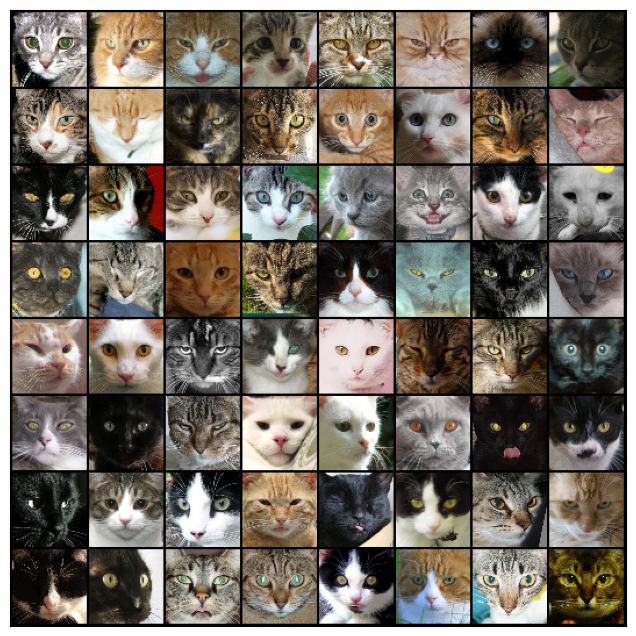

In [139]:
show_batch(train_dl)

In [140]:
def is_cuda_available():
    if torch.cuda.is_available():
        print("CUDA available. Training on GPU!")
        return torch.device('cuda')
    else:
        print("CUDA not available. Training on CPU!")
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [141]:
is_cuda_available()

CUDA available. Training on GPU!


device(type='cuda')

In [142]:
device=is_cuda_available()
train_dl = DeviceDataLoader(train_dl, device)

CUDA available. Training on GPU!


In [143]:
#basic cnn with convolutional layers and leaky relu as activation fn
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [144]:
discriminator = to_device(discriminator, device)

In [145]:
latent_size = 128
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


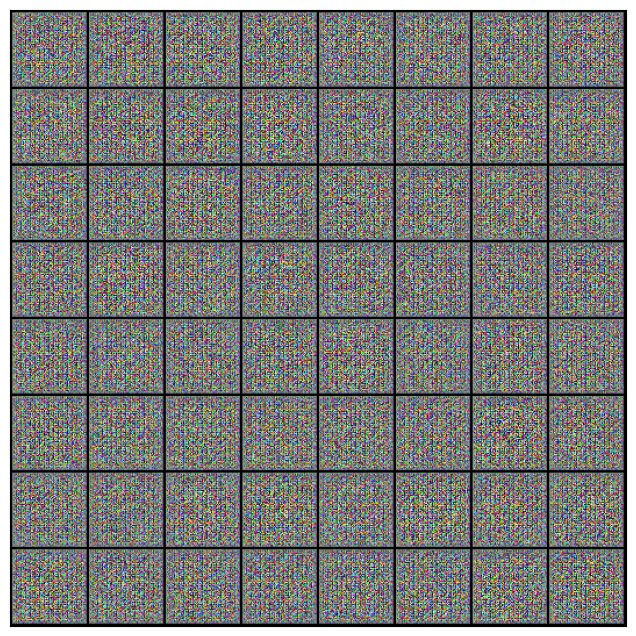

In [146]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [147]:
generator = to_device(generator, device)

In [148]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [149]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [150]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [151]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Saving generated-images-0000.png


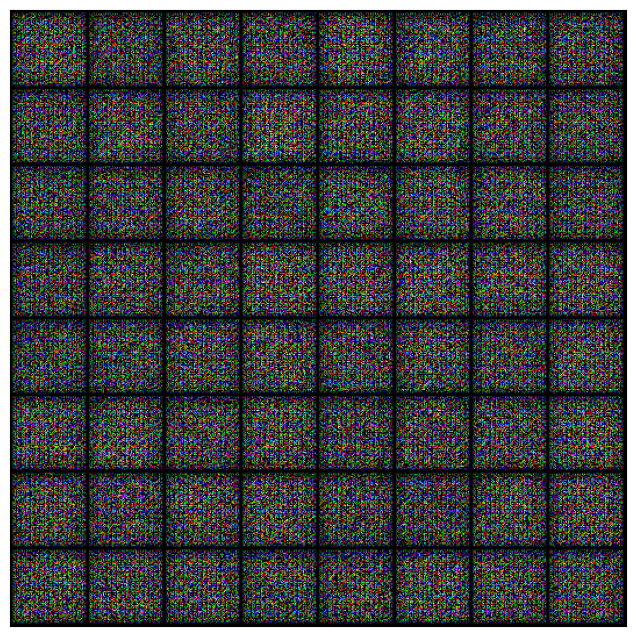

In [152]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
save_samples(0, fixed_latent)

In [153]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [154]:
lr = 0.0003
epochs = 60

In [155]:
history=fit(epochs,lr)

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [1/60], loss_g: 9.2771, loss_d: 0.4313, real_score: 0.9247, fake_score: 0.2611
Saving generated-images-0001.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [2/60], loss_g: 2.7269, loss_d: 0.6310, real_score: 0.7001, fake_score: 0.1982
Saving generated-images-0002.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [3/60], loss_g: 2.8299, loss_d: 0.6757, real_score: 0.6962, fake_score: 0.2201
Saving generated-images-0003.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [4/60], loss_g: 4.6448, loss_d: 0.8458, real_score: 0.8688, fake_score: 0.4719
Saving generated-images-0004.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [5/60], loss_g: 2.7187, loss_d: 0.8466, real_score: 0.6274, fake_score: 0.2397
Saving generated-images-0005.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [6/60], loss_g: 2.7989, loss_d: 0.7831, real_score: 0.8177, fake_score: 0.4090
Saving generated-images-0006.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [7/60], loss_g: 3.1742, loss_d: 0.9098, real_score: 0.5033, fake_score: 0.0462
Saving generated-images-0007.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [8/60], loss_g: 4.1331, loss_d: 0.6795, real_score: 0.9485, fake_score: 0.4296
Saving generated-images-0008.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [9/60], loss_g: 6.9768, loss_d: 1.1285, real_score: 0.8665, fake_score: 0.5731
Saving generated-images-0009.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [10/60], loss_g: 5.0604, loss_d: 1.0465, real_score: 0.7771, fake_score: 0.4871
Saving generated-images-0010.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [11/60], loss_g: 2.7226, loss_d: 1.3063, real_score: 0.9338, fake_score: 0.6437
Saving generated-images-0011.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [12/60], loss_g: 3.8373, loss_d: 0.8134, real_score: 0.7521, fake_score: 0.3465
Saving generated-images-0012.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [13/60], loss_g: 4.0634, loss_d: 0.5750, real_score: 0.8402, fake_score: 0.2942
Saving generated-images-0013.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [14/60], loss_g: 4.3601, loss_d: 0.8464, real_score: 0.7440, fake_score: 0.3621
Saving generated-images-0014.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [15/60], loss_g: 2.5987, loss_d: 0.6616, real_score: 0.8205, fake_score: 0.2939
Saving generated-images-0015.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [16/60], loss_g: 5.1643, loss_d: 0.7678, real_score: 0.9204, fake_score: 0.4549
Saving generated-images-0016.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [17/60], loss_g: 4.2820, loss_d: 0.6512, real_score: 0.7569, fake_score: 0.2712
Saving generated-images-0017.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [18/60], loss_g: 2.0217, loss_d: 1.1156, real_score: 0.4433, fake_score: 0.0574
Saving generated-images-0018.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [19/60], loss_g: 3.5535, loss_d: 0.6352, real_score: 0.8918, fake_score: 0.3637
Saving generated-images-0019.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [20/60], loss_g: 3.0706, loss_d: 0.9830, real_score: 0.5415, fake_score: 0.1417
Saving generated-images-0020.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [21/60], loss_g: 3.4947, loss_d: 0.6853, real_score: 0.6011, fake_score: 0.0810
Saving generated-images-0021.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [22/60], loss_g: 5.0327, loss_d: 0.6280, real_score: 0.8381, fake_score: 0.3383
Saving generated-images-0022.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [23/60], loss_g: 3.7588, loss_d: 0.4395, real_score: 0.7555, fake_score: 0.1083
Saving generated-images-0023.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [24/60], loss_g: 2.8987, loss_d: 0.6236, real_score: 0.6390, fake_score: 0.0941
Saving generated-images-0024.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [25/60], loss_g: 3.6122, loss_d: 0.2230, real_score: 0.8877, fake_score: 0.0879
Saving generated-images-0025.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [26/60], loss_g: 6.6334, loss_d: 0.4472, real_score: 0.9275, fake_score: 0.2822
Saving generated-images-0026.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [27/60], loss_g: 1.2784, loss_d: 0.9687, real_score: 0.4379, fake_score: 0.0389
Saving generated-images-0027.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [28/60], loss_g: 2.7454, loss_d: 0.3381, real_score: 0.7792, fake_score: 0.0571
Saving generated-images-0028.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [29/60], loss_g: 5.6512, loss_d: 0.4858, real_score: 0.6425, fake_score: 0.0023
Saving generated-images-0029.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [30/60], loss_g: 6.6641, loss_d: 0.7223, real_score: 0.9619, fake_score: 0.4529
Saving generated-images-0030.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [31/60], loss_g: 3.7775, loss_d: 2.3950, real_score: 0.1466, fake_score: 0.0010
Saving generated-images-0031.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [32/60], loss_g: 4.6523, loss_d: 0.7705, real_score: 0.5278, fake_score: 0.0063
Saving generated-images-0032.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [33/60], loss_g: 2.3703, loss_d: 0.2138, real_score: 0.8659, fake_score: 0.0559
Saving generated-images-0033.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [34/60], loss_g: 3.5350, loss_d: 0.7069, real_score: 0.9854, fake_score: 0.4207
Saving generated-images-0034.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [35/60], loss_g: 8.5929, loss_d: 1.3935, real_score: 0.9196, fake_score: 0.6746
Saving generated-images-0035.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [36/60], loss_g: 3.4634, loss_d: 0.1422, real_score: 0.9594, fake_score: 0.0920
Saving generated-images-0036.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [37/60], loss_g: 2.7816, loss_d: 0.2747, real_score: 0.8343, fake_score: 0.0642
Saving generated-images-0037.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [38/60], loss_g: 5.7745, loss_d: 0.8202, real_score: 0.9619, fake_score: 0.4889
Saving generated-images-0038.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [39/60], loss_g: 3.0717, loss_d: 0.4906, real_score: 0.6882, fake_score: 0.0532
Saving generated-images-0039.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [40/60], loss_g: 4.0157, loss_d: 0.2307, real_score: 0.9374, fake_score: 0.1395
Saving generated-images-0040.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [41/60], loss_g: 4.0659, loss_d: 0.1210, real_score: 0.9620, fake_score: 0.0760
Saving generated-images-0041.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [42/60], loss_g: 4.0766, loss_d: 0.2960, real_score: 0.9056, fake_score: 0.1487
Saving generated-images-0042.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [43/60], loss_g: 4.9794, loss_d: 0.3572, real_score: 0.9460, fake_score: 0.2397
Saving generated-images-0043.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [44/60], loss_g: 4.9577, loss_d: 0.0825, real_score: 0.9381, fake_score: 0.0139
Saving generated-images-0044.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [45/60], loss_g: 5.4694, loss_d: 0.4858, real_score: 0.6634, fake_score: 0.0127
Saving generated-images-0045.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [46/60], loss_g: 3.1931, loss_d: 0.4628, real_score: 0.7329, fake_score: 0.0791
Saving generated-images-0046.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [47/60], loss_g: 7.4823, loss_d: 0.3618, real_score: 0.7271, fake_score: 0.0016
Saving generated-images-0047.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [48/60], loss_g: 4.9589, loss_d: 0.0458, real_score: 0.9811, fake_score: 0.0258
Saving generated-images-0048.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [49/60], loss_g: 6.1841, loss_d: 0.2682, real_score: 0.9109, fake_score: 0.1446
Saving generated-images-0049.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [50/60], loss_g: 6.6235, loss_d: 0.0490, real_score: 0.9573, fake_score: 0.0041
Saving generated-images-0050.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [51/60], loss_g: 3.8905, loss_d: 0.1351, real_score: 0.9025, fake_score: 0.0127
Saving generated-images-0051.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [52/60], loss_g: 6.3396, loss_d: 0.2785, real_score: 0.9739, fake_score: 0.2031
Saving generated-images-0052.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [53/60], loss_g: 4.6123, loss_d: 0.3281, real_score: 0.7598, fake_score: 0.0147
Saving generated-images-0053.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [54/60], loss_g: 3.4627, loss_d: 0.3153, real_score: 0.8000, fake_score: 0.0425
Saving generated-images-0054.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [55/60], loss_g: 5.1779, loss_d: 0.4024, real_score: 0.9486, fake_score: 0.2521
Saving generated-images-0055.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [56/60], loss_g: 3.6354, loss_d: 0.0617, real_score: 0.9967, fake_score: 0.0541
Saving generated-images-0056.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [57/60], loss_g: 5.0103, loss_d: 0.1629, real_score: 0.9482, fake_score: 0.0969
Saving generated-images-0057.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [58/60], loss_g: 5.0683, loss_d: 0.3180, real_score: 0.9741, fake_score: 0.1995
Saving generated-images-0058.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [59/60], loss_g: 3.1700, loss_d: 0.0614, real_score: 0.9884, fake_score: 0.0460
Saving generated-images-0059.png


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch [60/60], loss_g: 7.1665, loss_d: 0.4048, real_score: 0.9394, fake_score: 0.2486
Saving generated-images-0060.png


In [163]:
losses_g, losses_d, real_scores, fake_scores = history

In [164]:
from IPython.display import Image

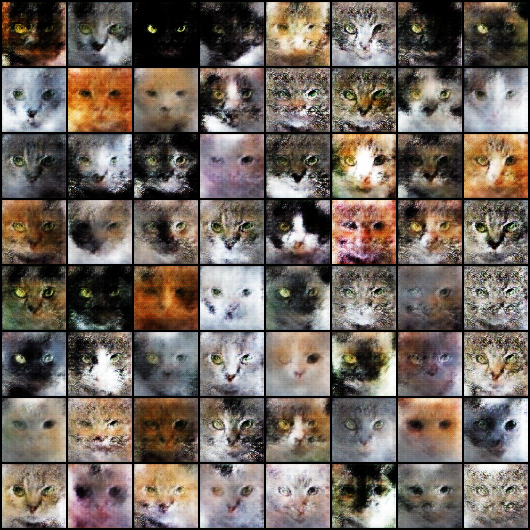

In [165]:
Image('./generated/generated-images-0033.png')

In [166]:
vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

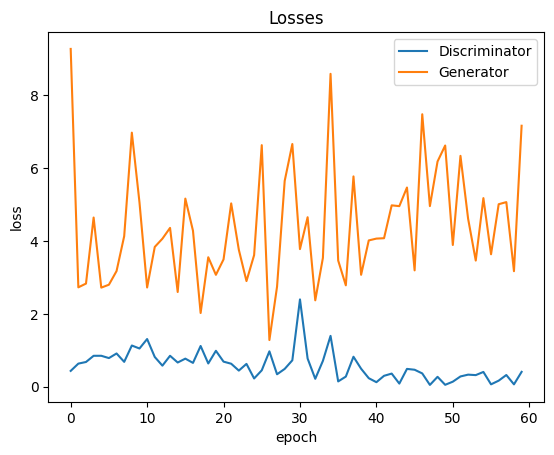

In [167]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

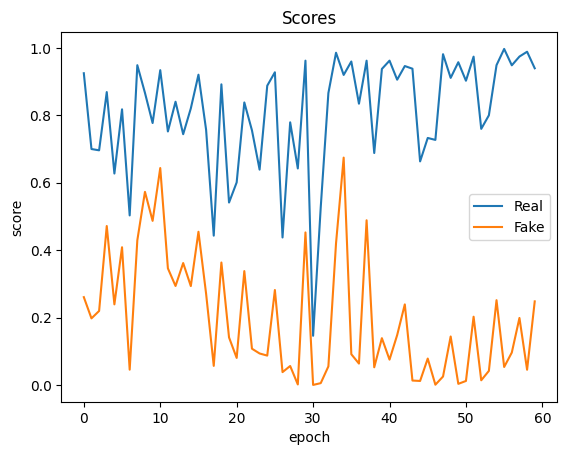

In [168]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

Saving generated-images-0000.png


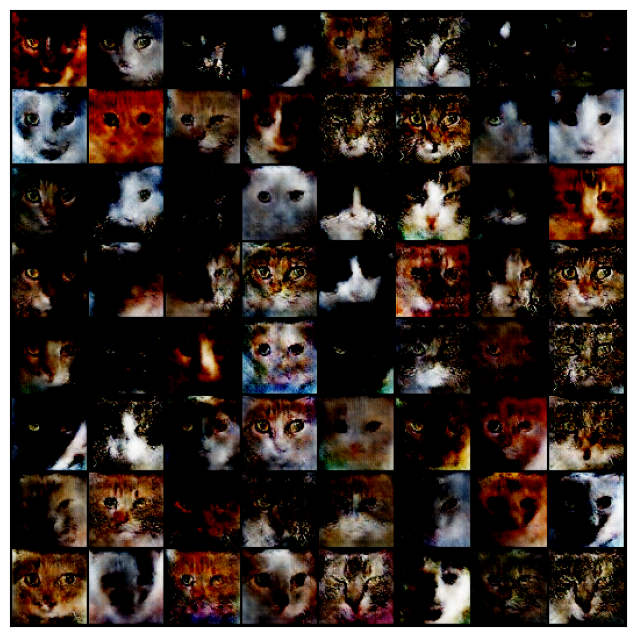

In [170]:
save_samples(0, fixed_latent)